### Actors

* **id**: Não indexar
* **name**: Indexar
* **movies** : Indexar
* **characters** (array): Indexar
* **related_actors** (array): Indexar

Lista de tipos de filtros que se propõe implementar para o ```name```, incrementalmente:

1. **Soundex matching**: Elin and Ellen
2. **Levenstein matching**: Jonn matches John, etc.
3. **Accent folding**: Jorn matches Jörn and vise versa
5. **Shortened representations**: Jon matches Jonathan, etc.

Começando então pelo **Soundex matching**, adicionar o filtro **Beider-Morse**.
Temos o exemplo do nome Allan, que pode ser escrito de diversas formas:

* Alan
* Allen
* Alain
* Alen
* Alun
* Allyn
* Allain

Ao pesquisar por Allan, por exemplo, queremos que todos os nomes acima sejam retornados, com um score de similaridade. O mesmo vale para Allen, Alain, etc. Ora, quanto mais próximo o nome estiver de Allan, maior o score de similaridade. 

Antes de implementar o filtro, vamos ver como ele funciona. 
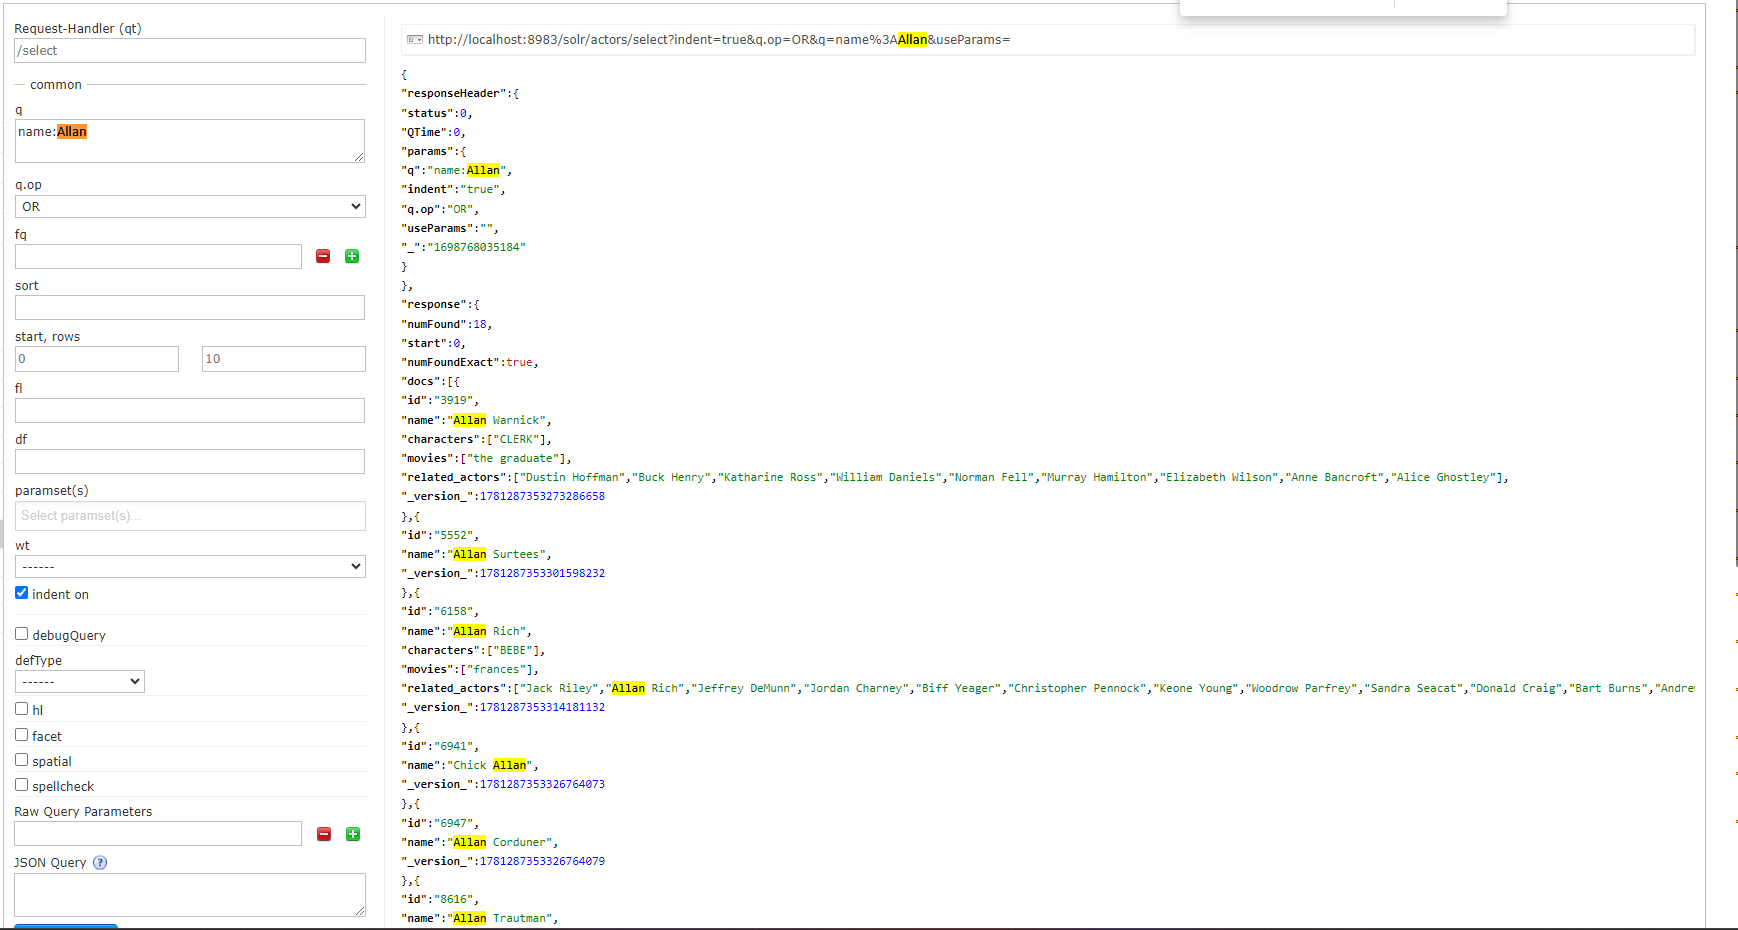




Para aplicar o filtro, cria-se um ```field-type``` que vai ter unicamente o filtro Beider-Morse. Depois, cria-se uma cópia do field ```name```, chamada ```name_phonetic```, que vai ter o field-type criado anteriormente.

Ao pesquisar Allan, com ```q={Allan}, qf={name^2 name_phonetic^1}```, vê-se que primeiramente vai procurar exact matches e, de seguida, retorna os resultados com maior score de similaridade fonética (Alan, Allen, Alain, etc.):
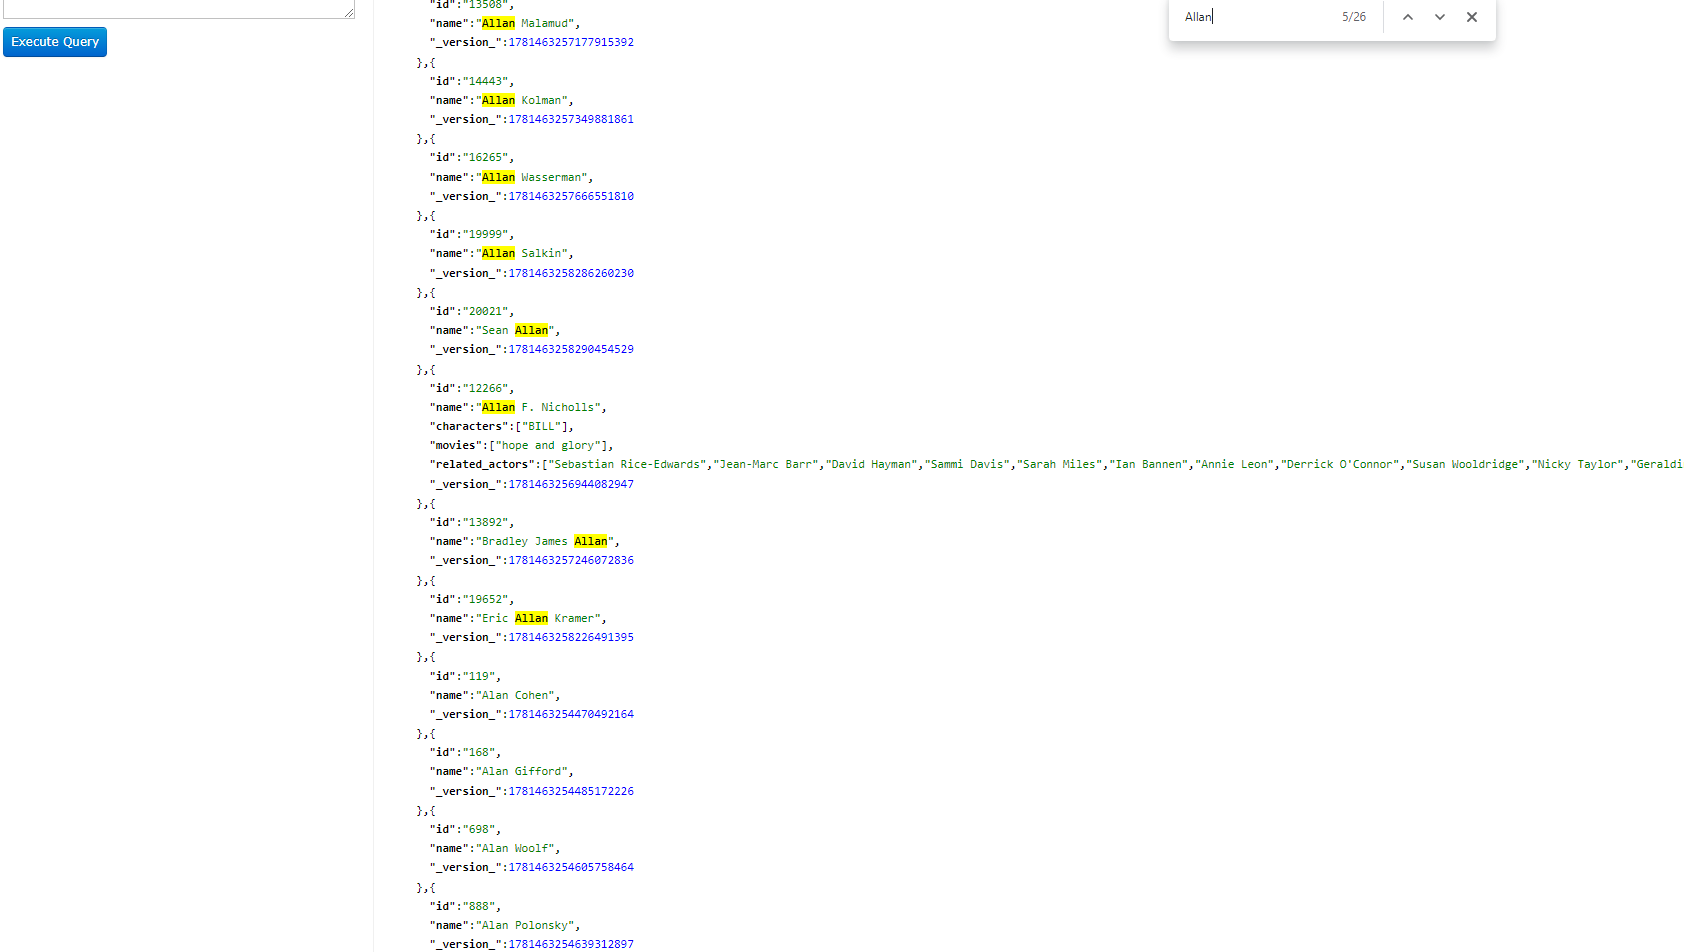

Para implementar Levenstein matching, vamos optar por usar o built-in ```Lucene fuzzy search operator``` do Solr. Para isso, basta adicionar ```~``` no final da query, com um número que indica o número de caracteres que podem ser diferentes.

No entanto, é preciso dar, mais uma vez, prioridade às exact matches, pelo que a query seria ```q={name:Jon^2 name:Jon~2} ```.
Como se vê, primeiro retorna Jon, depois Joe, Ján, Ron, Joy, etc.:
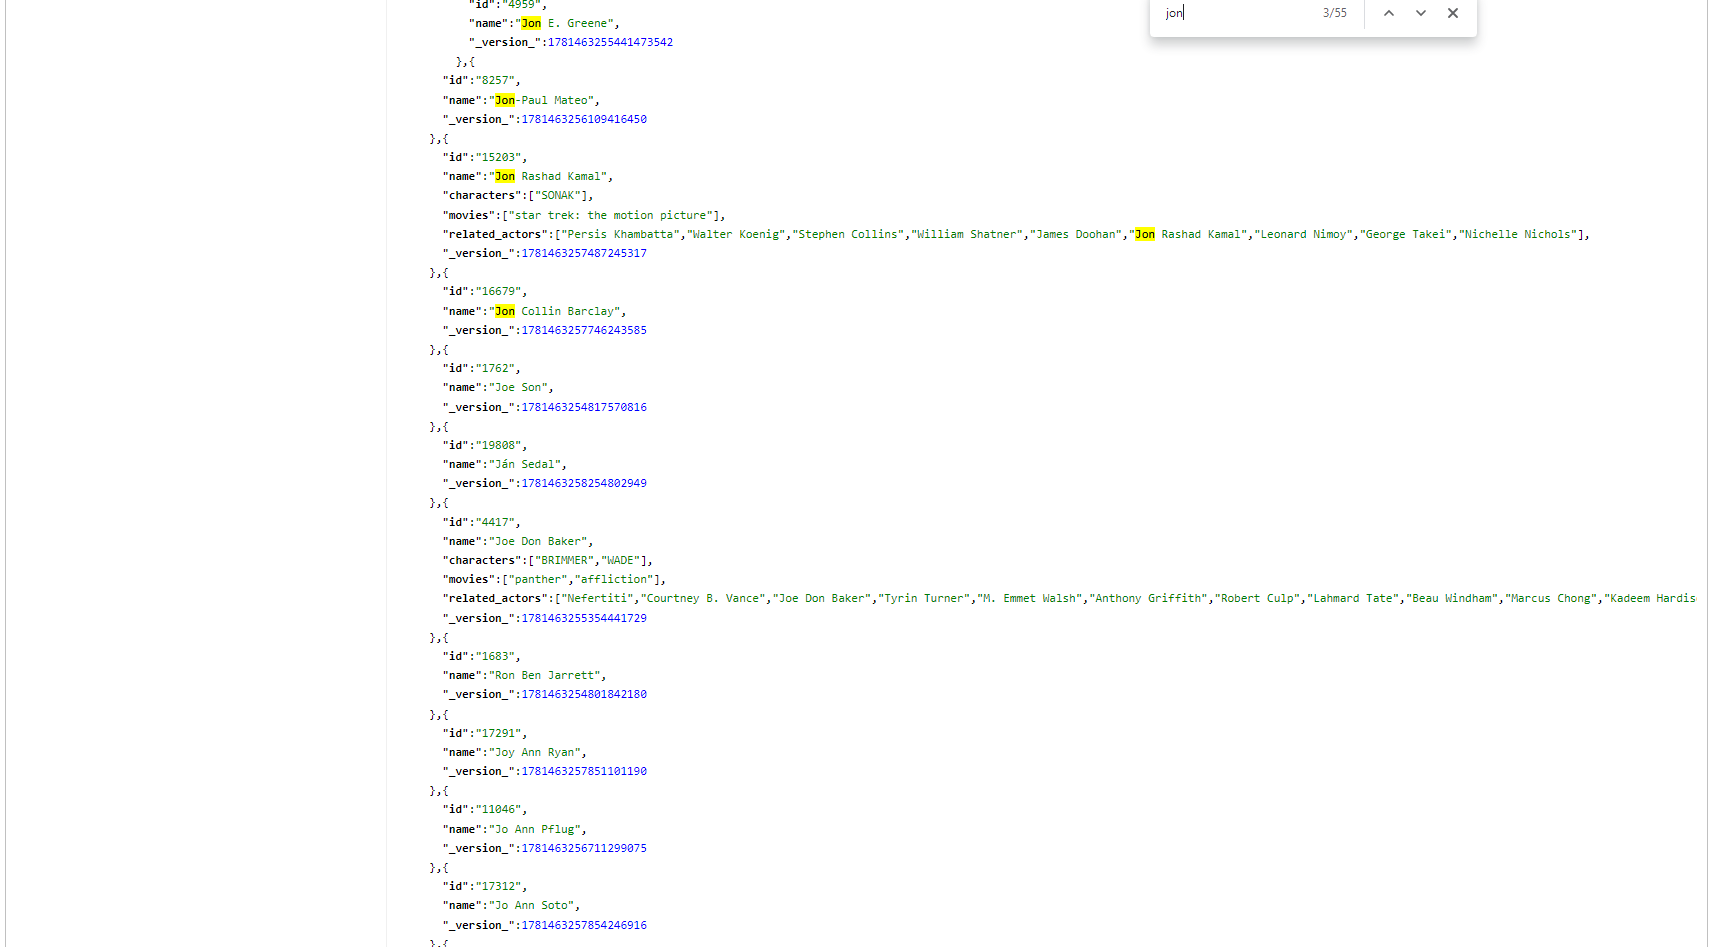

Para implementar Accent folding, vamos usar o filtro ```asciifolding```. Este filtro converte caracteres com acentos para caracteres sem acentos. Por exemplo, o nome Jörn é convertido para Jorn.

Por fim, para implementar **Shortened Representations** vamos utilizar o filtro ```SynonymGraphFilterFactory```. Fornecemos um ficheiro name_synonyms.txt que segue um formato específico para este filtro. Exemplo de uma entrada desse ficheiro:

```sofi => sofia, sofie, sophia, sophie, sophronia, sophy, zofka```

Ou seja, quando o nome Sofi é encontrado, é feita uma pesquisa por todos os nomes que estão à direita da seta. 

A abordagem que eu fiz foi criar um novo field ```name_synonyms``` que vai ter o filtro ```SynonymGraphFilterFactory```. Depois, criei uma cópia do field ```name``` que tem como destino este novo field criado.

Notar que este filtro é apenas utilizado no index e não é utilizado na query. Esta decisão é derivada do facto de termos todas as combinações possíveis de nomes e respetivos sinónimos no ficheiro .txt, o que faz com que não seja necessário converter uma query para os seus sinónimos, dado que já sabemos a priori que esse campo pesquisado na query vai pertencer a uma das entradas do ficheiro .txt. Isto implica que quando quisermos adicionar novos sinónimos, temos de reindexar o campo ```name_synonyms``` (voltar a gerar os documentos do core actors).

Utilizou-se ```expanded=false``` porque cada nome tem muitos sinónimos associados. 

Só faria sentido utilizar ```expanded=true``` se tivéssemos uma entrada com o seguinte formato: ```sofi, sofia, sofie, sophia, sophie, sophronia, sophy, zofka```. Neste caso, como não está definido qual é o nome original, é preciso expandir todos os sinónimos.

Vamos então ver como funciona o filtro. Ao pesquisar por ```q={name_synonyms:Sofi}``` , vemos que retorna todos os nomes que estão à direita da seta:

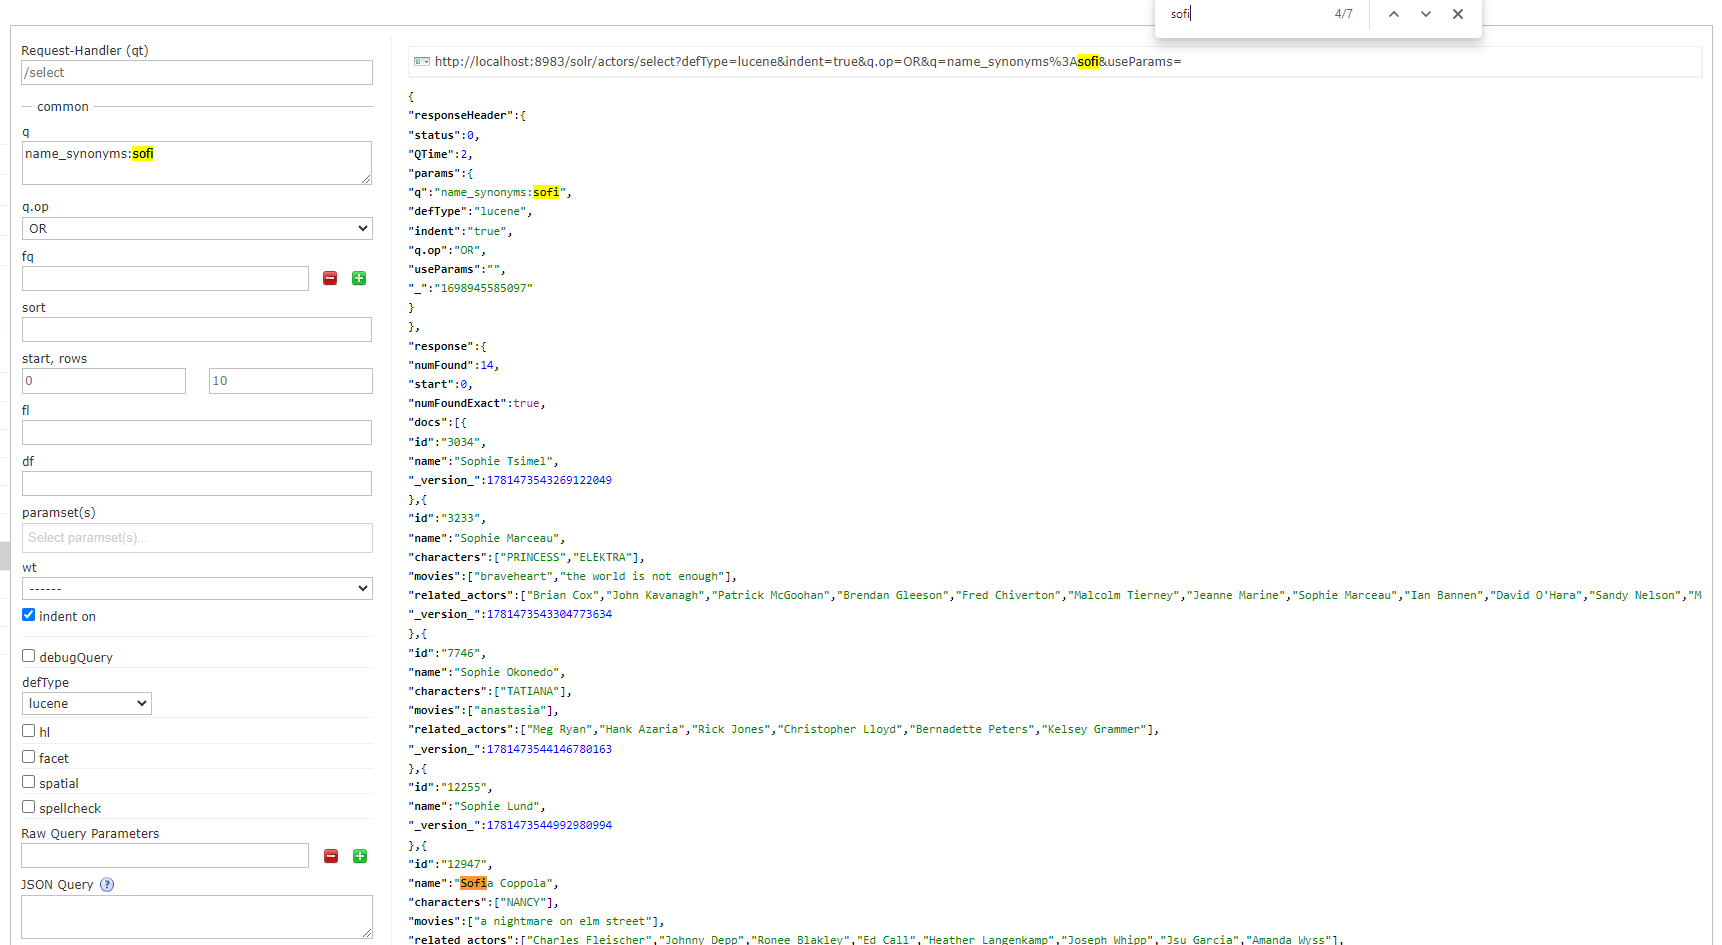

Também podemos dar match boost às exact matches, com ```defType = dismax``` e ```qf = {name^2 name_synonyms}```. Neste caso, a query é ```q={sophia}```.
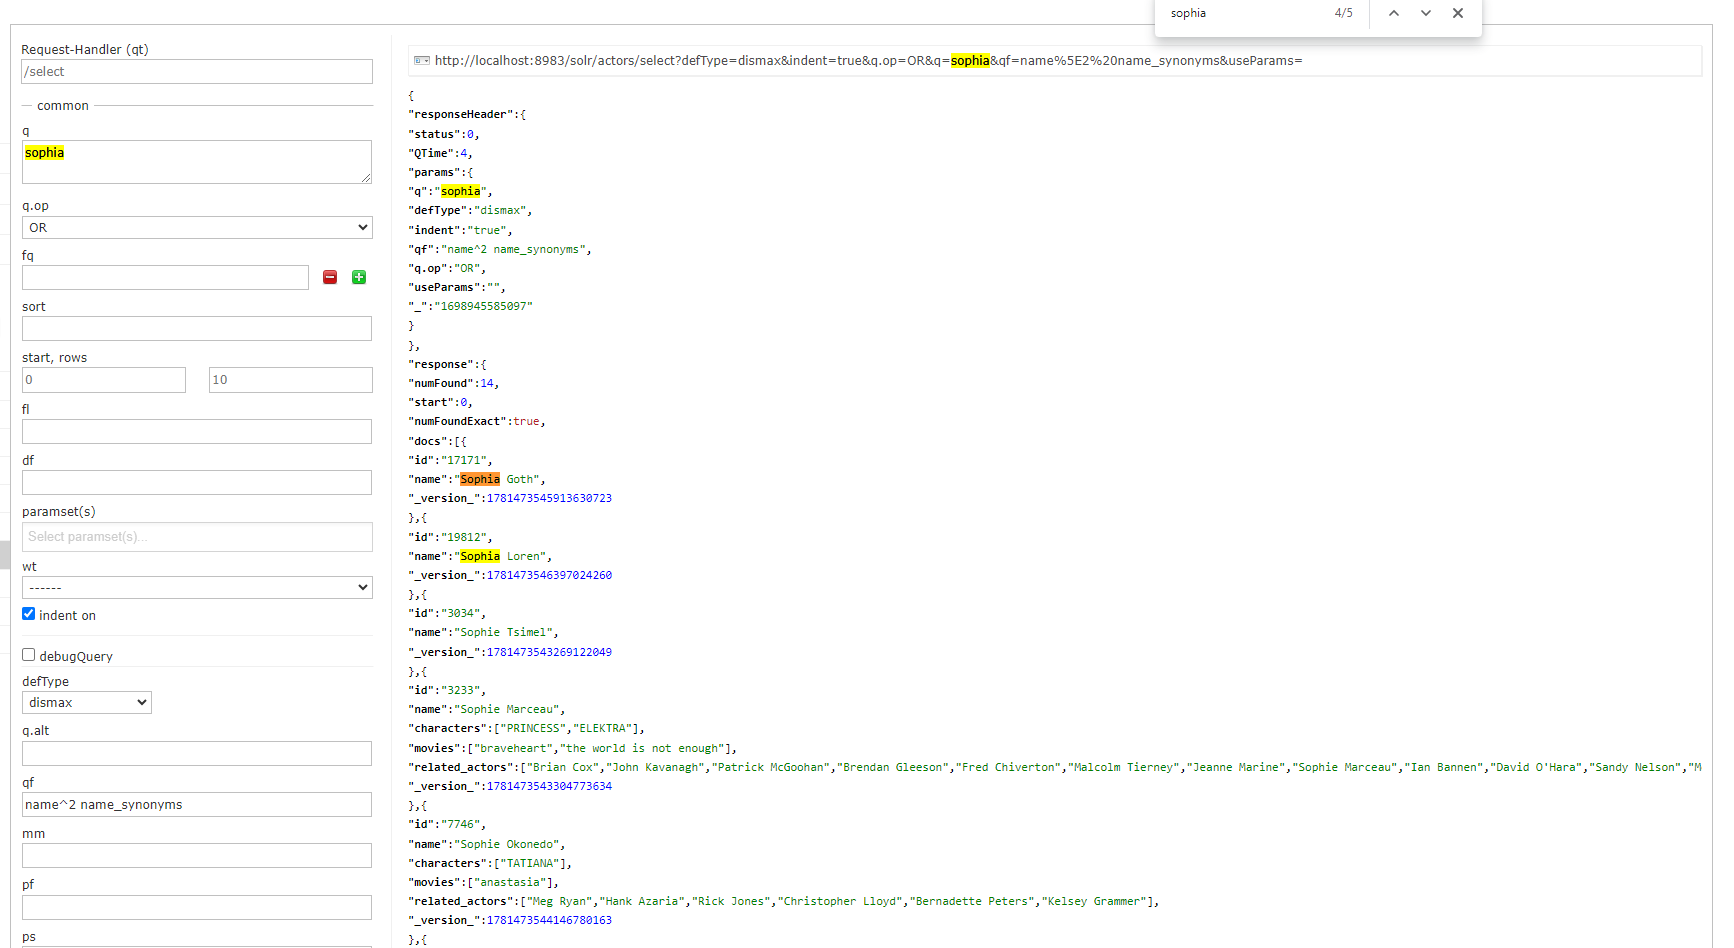

Por fim, para juntar todo o tipo de filtros, podemos definir uma query com o ```defType = dismax```, onde pesquisamos ```q={sóphia}``` e pomos ```qf={name^3 name_phonetic^2 name_synonyms}```.
Assim, primeiro serão retornadas as exact matches, depois serão retornadas palavras foneticamente semelhantes e, por fim, os sinónimos.